# Intenisty, flux and luminosity 

We will explore this tree quantities in context of observed solar spectrum and compare results obtained using emulator as well as black body.

In [1]:
from transformer_payne import BlackbodyFlux, TransformerPayne, air_to_vac
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

If some of the python libraries are missing try to install them using:
```
!pip install matplotlib
!pip install pandas
```
First initialize our emulators:

In [3]:
bb_emulator = BlackbodyFlux()
spec_emulator = TransformerPayne.download()
# When the emulator is downloaded, it is saved in the cache folder. Then you can load it from there:
# spec_emulator = TransformerPayne.from_file(".cache/TPAYNE/TransformerPayneIntensities_v1.pkl")

In [4]:
observed_sun_intensities = pd.read_csv("data/Spectra_HR_directions_650_700.csv") # From Meftah+2023
observed_sun_irradiance = pd.read_csv("data/Spectrum_HR_integrated_650_700.csv") # From Meftah+2023

# Convert irradiance to flux:
observed_sun_flux = observed_sun_irradiance[:]
R_sun = 695700e5 # cm
d_sun = 1.496e13 # cm
T_sun = 5777 # K
sigma_SB = 5.670374419e-5 # erg/cm^2/s/K^4 Stefan-Boltzmann constant

observed_sun_flux["flux"] = observed_sun_flux["flux"] * d_sun**2 / R_sun**2 # W/m^2/m

## Compare intensities

In [5]:
wave = np.linspace(3000, 11000, 10000)
wave_zoom = np.linspace(6500, 6600, 10000)
parameters = spec_emulator.solar_parameters
mu = 1.0

log_wave = np.log10(wave)
log_wave_zoom = np.log10(wave_zoom)

# Calculate the blackbody intensities
bb_intensities = bb_emulator.intensity(log_wave, mu, T_sun)
spec_intensities = spec_emulator(log_wave, mu, parameters)
spec_intensities_zoom = spec_emulator(log_wave_zoom, mu, parameters)

(6500.0, 6600.0)

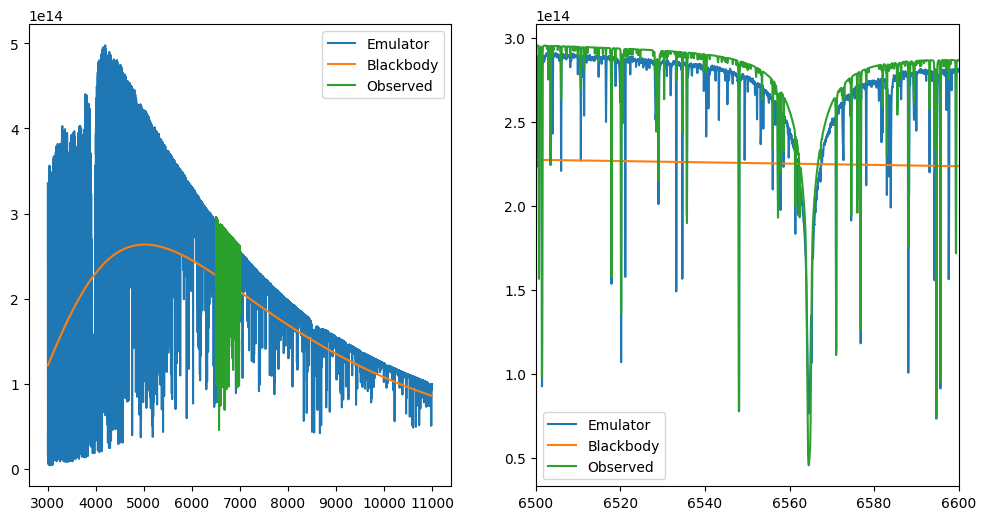

In [6]:
# Plot the blackbody and the emulator intensities
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# on the top full on the bottom zoomed in
axs[0].plot(wave, spec_intensities[:,0], label="Emulator")
axs[0].plot(wave, bb_intensities[:,0], label="Blackbody")
axs[0].plot(observed_sun_intensities["wavelength"], observed_sun_intensities["mu1"], label="Observed")
axs[0].legend()

axs[1].plot(wave_zoom, spec_intensities_zoom[:,0], label="Emulator")
axs[1].plot(wave, bb_intensities[:,0], label="Blackbody")
axs[1].plot(observed_sun_intensities["wavelength"], observed_sun_intensities["mu1"], label="Observed")
axs[1].legend()
axs[1].set_xlim(6500, 6600)

### Integrate flux manually

In [7]:
no_mus = 10

# Gauss-Legendre quadrature nodes and weights for the integration:
nodes, weights = np.polynomial.legendre.leggauss(no_mus)
nodes = (nodes + 1) / 2
weights /= 2

mus = nodes
wave = np.linspace(3000, 11000, 10000)
wave_zoom = np.linspace(6500, 6600, 10000)
log_wave = np.log10(wave)
log_wave_zoom = np.log10(wave_zoom)

# We don't need to calculate the blackbody intensities for each mu, we can just calculate it once as it is independent of mu (isotropic)
# But we will naively calculate it for each mu for the sake of the example
# Calculate emulator intensities for each mu
spec_intensities = []
spec_intensities_zoom = []
bb_intensities = []
for i, mu in enumerate(mus):
    print(f"Calculating: {i+1}/{no_mus}")
    si = spec_emulator(log_wave, mu, spec_emulator.solar_parameters)
    spec_intensities.append(si)

    si_zoom = spec_emulator(log_wave_zoom, mu, spec_emulator.solar_parameters)
    spec_intensities_zoom.append(si_zoom)

    bi = bb_emulator.intensity(log_wave, mu, T_sun)
    bb_intensities.append(bi)

# Integrate:
spec_fluxes = np.array(spec_intensities)*mus[:, None, None]*weights[:, None, None]
spec_fluxes = 2*np.pi*spec_fluxes.sum(axis=0)

spec_fluxes_zoom = np.array(spec_intensities_zoom)*mus[:, None, None]*weights[:, None, None]
spec_fluxes_zoom = 2*np.pi*spec_fluxes_zoom.sum(axis=0)

bb_fluxes = np.array(bb_intensities)*mus[:, None, None]*weights[:, None, None]
bb_fluxes = 2*np.pi*bb_fluxes.sum(axis=0)

bb_fluxes_exact = bb_emulator.flux(log_wave, T_sun)

Calculating: 1/10
Calculating: 2/10
Calculating: 3/10
Calculating: 4/10
Calculating: 5/10
Calculating: 6/10
Calculating: 7/10
Calculating: 8/10
Calculating: 9/10
Calculating: 10/10


(6500.0, 6600.0)

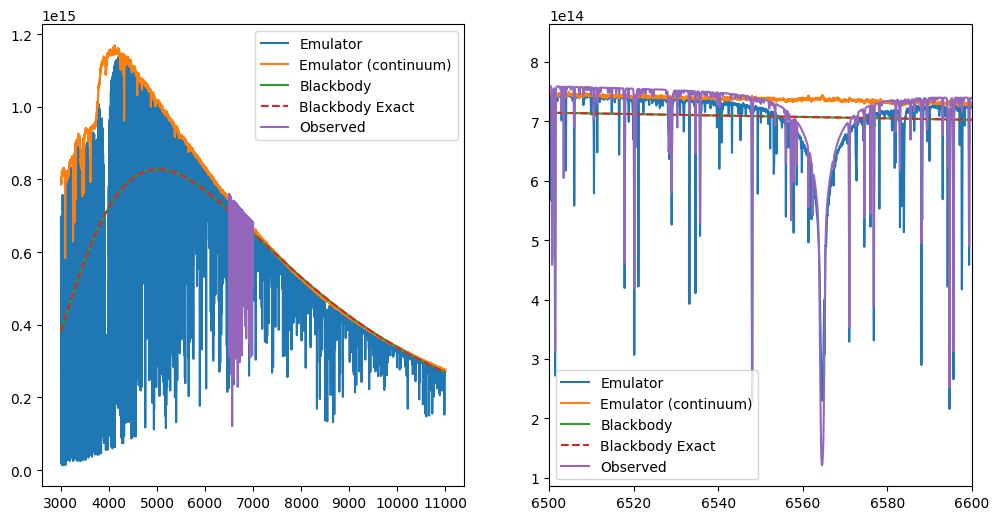

In [8]:
# Plot the blackbody and the emulator intensities
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# on the top full on the bottom zoomed in
axs[0].plot(wave, spec_fluxes[:,0], label="Emulator")
axs[0].plot(wave, spec_fluxes[:,1], label="Emulator (continuum)")
axs[0].plot(wave, bb_fluxes[:,0], label="Blackbody")
axs[0].plot(wave, bb_fluxes_exact[:,0],"--", label="Blackbody Exact")
axs[0].plot(observed_sun_flux["wavelength"], observed_sun_flux["flux"], label="Observed")
axs[0].legend()

axs[1].plot(wave_zoom, spec_fluxes_zoom[:,0], label="Emulator")
axs[1].plot(wave_zoom, spec_fluxes_zoom[:,1], label="Emulator (continuum)")
axs[1].plot(wave, bb_fluxes[:,0], label="Blackbody")
axs[1].plot(wave, bb_fluxes_exact[:,0], "--", label="Blackbody Exact")
axs[1].plot(observed_sun_flux["wavelength"], observed_sun_flux["flux"], label="Observed")
axs[1].legend()
axs[1].set_xlim(6500, 6600)

### Integrate Luminosity in filter (300 - 1100 nm)

Using fluxes integrated above:

In [9]:
L_spec = np.trapz(spec_fluxes[:,0], x = wave*1e-8) * 4*np.pi*R_sun**2 # erg/s
L_bb_exact = np.trapz(bb_fluxes_exact[:,0], x = wave*1e-8) * 4*np.pi*R_sun**2 # erg/s
relative_difference = (L_bb_exact - L_spec) / L_bb_exact
print(f"Relative difference: {relative_difference*100:.2f}%, L_spec: {L_spec:.2e} [erg/s], L_bb_exact: {L_bb_exact:.2e} [erg/s]")

Relative difference: 1.00%, L_spec: 2.79e+33 [erg/s], L_bb_exact: 2.82e+33 [erg/s]


Reasure ourselfs that we are doing proper integration by comparing to Stefan-Boltzmann law:

In [11]:
# Solar luminosity using stefan-boltzmann law:
L_bol = sigma_SB * T_sun**4 * 4*np.pi*R_sun**2 # erg/s

wave_bb = np.linspace(100, 100000, 10000)
bb_fluxes_exact = bb_emulator.flux(np.log10(wave_bb), T_sun)
L_bo_bb_exact = np.trapz(bb_fluxes_exact[:,0], x = wave_bb*1e-8) * 4*np.pi*R_sun**2 # erg/s

print(f"Relative difference: {(L_bol - L_bo_bb_exact) / L_bol * 100:.2f}%, L_bol: {L_bol:.2e} [erg/s], L_bo_bb_exact: {L_bo_bb_exact:.2e} [erg/s]")

Relative difference: 0.07%, L_bol: 3.84e+33 [erg/s], L_bo_bb_exact: 3.84e+33 [erg/s]


In [ ]:
ś